
# ALL FastAI Resnet 50(a) Classifier
The ALL FastAI Resnet 50(a) Classifier was created by  [Adam Milton-Barker](https://github.com/AdamMiltonBarker) based on [Salvatore Raieli's](https://github.com/salvatorera) [Resnet50](https://github.com/AMLResearchProject/AML-ALL-Classifiers/blob/master/Python/_FastAI/Resnet50/ALL-FastAI-Resnet-50.ipynb) project. The classifier provides a Google Colab notebook that uses FastAI with Resnet50 and ALL_IDB2 from the [Acute Lymphoblastic Leukemia Image Database for Image Processing dataset](https://homes.di.unimi.it/scotti/all/). 

# FastAI Resnet50(a) Classifier Project Contributors

- [Salvatore Raieli](https://github.com/salvatorera "Salvatore Raieli") - PhD Immunolgy / Bioinformaticia, Bologna, Italy
- [Adam Milton-Barker](https://github.com/AdamMiltonBarker "Adam Milton-Barker") - Bigfinite IoT Network Engineer & Intel Software Innovator, Barcelona, Spain

# Google Drive / Colab
This tutorial assumes you have access to [Google Drive](https://www.google.com/drive/) with enough space to save the dataset and related files. It is also assumed that you have access to [Google Colab](https://colab.research.google.com).

# Import data to Google Drive
You need to import **ALL_IDB2** from the [Acute Lymphoblastic Leukemia Image Database for Image Processing dataset](https://homes.di.unimi.it/scotti/all/) dataset, to do this you need to request permission from Fabio Scotti, the creator of the dataset. You can request permission by following the steps provided on [this page](https://homes.di.unimi.it/scotti/all/#download). 

Once you have permission you need to upload the negative and positive examples provided in **ALL_IDB2** to your Google Drive. In this tutorial we assume you have uploaded your copy of the dataset to a folder located on your Google drive with the location: *My Drive/fastai-v3/ALL_IDB2*. Once you have uploaded the dataset you can continue with this tutorial.

# Clone the AML-ALL-Classifiers repository
First we need to clone the repository so that we can upload this notebook to Google Colab. To do so you can clone the repository using the command below, alternatively you can "Download as ZIP" from the [repository homepage](https://github.com/AMLResearchProject/AML-ALL-Classifiers).


```
git clone https://github.com/AMLResearchProject/AML-ALL-Classifiers.git
```

Once you have cloned the repository, you will find this tutorial in the location: *AML-ALL-Classifiers/Python/_FastAI/Resnet50/ALL-FastAI-Resnet-50-a.ipynb*, you can now upload this to Google Colab and continue with this tutorial.

# Google Colab 

**You should now be running this tutorial on Google Colab, if not please read this tutorial from the beginning. **  

First we need import the Google Colab Drive library, mount our dataset drive from Google Drive, and set the path to the ALL_IDB2 folder on your drive. Run the following code block to do this. You will be asked to click a link that will authorize the application with the permissions it needs to mount your drive etc. Follow the steps and then past the authorization key into this application.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
dataset_dir = "/content/gdrive/My Drive/fastai-v3/ALL_IDB2"

Mounted at /content/gdrive


# Import required libraries
We need to import the relevant FastAI libraries, running the following code block with do this and get the paths to the dataset files.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
fileNames = get_image_files(dataset_dir)
fileNames[:5]

[PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im187_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im189_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im001_1.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im002_1.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im190_0.tif')]

# Import datset
Now we need to import the dataset into this notebook. run the following code blocks to import the ALL_IDB2 dataset as a FastAI [DataBunch](https://docs.fast.ai/basic_data.html#DataBunch). In the ImageDataBunch.from_name_re function we can see that we pass the *dataset_dir* we created earlier in the tutorial, fileNames that we created earlier,  pattern for the files, some augmentation, the size of the images we need to match Resnet50 input sizes and the number of batches.  We then normalize the data using .normalize(imagenet_stats).

For more information about getting datasets ready with FastAI you can check out [this article](https://docs.fast.ai/vision.data.html#Quickly-get-your-data-ready-for-training).

In [0]:
np.random.seed(2)
pattern = r'/\w+_(\d)\.tif$'

In [4]:
data = ImageDataBunch.from_name_re(dataset_dir, fileNames, pattern, ds_tfms=get_transforms(), 
                                   size=224, bs=64).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (208 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,0,0
Path: /content/gdrive/My Drive/fastai-v3/ALL_IDB2;

Valid: LabelList (51 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,1,1
Path: /content/gdrive/My Drive/fastai-v3/ALL_IDB2;

Test: None

# data.show_batch()
Now we use the [data.show_batch()](https://docs.fast.ai/basic_data.html#DataBunch.show_batch) function to show a batch of our data. Run the following code block to do this and view the results.

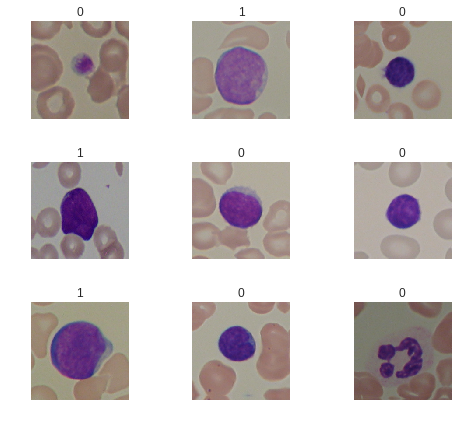

In [5]:
data.show_batch(rows=3, figsize=(7,6))

## View classes info
Now we can run the following code block which will print out the classes list and lengths.

In [6]:
print(data.classes)
len(data.classes),data.c

['0', '1']


(2, 2)

# Test the Resnet50 architecture with our dataset
Now we are going to test how the FastaAI implementation of Resnet50 works with the ALL_IDB2 dataset. 

## Create the convolutional neural network

First we will create the convolutional neural network based on Resnet50, to do this we can use the following code block which uses FastAI  ( [*cnn_learner*](https://docs.fast.ai/vision.learner.html#cnn_learner) previously *create_cnn*) function. We pass the loaded data, specify the resnet50 model, pass error_rate & accuracy as a list for the metrics parameter specifying we want to see both error_rate and accuracy,  and finally specify a weight decay of 1e-1 (1.0).

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy], wd=1e-1)

# learn.lr_find() & learn.recorder.plot()
Now we will use the [learn.lr_find()](https://docs.fast.ai/basic_train.html#lr_find) function to run LR Finder. LR Finder finds the best learning rate to use with our network. As shown from the output of above,  [learn.recorder.plot()](https://docs.fast.ai/basic_train.html#Recorder.plot) function can be used to view the graph. Run the following code block to view the graph.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


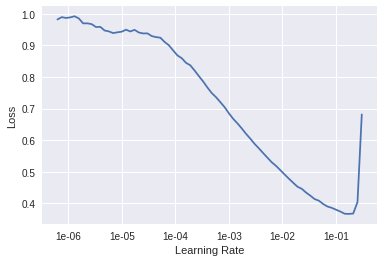

In [8]:
learn.lr_find()
learn.recorder.plot()

# learn.fit_one_cycle() & learn.recorder.plot_losses()
The [learn.fit_one_cycle()](https://docs.fast.ai/basic_train.html#fit_one_cycle) function can be used to fit the model. We use 5 for the parameter *cyc_len* to specify the number of cycles to run, and *max_lr* to specify the maximum learning rate to use which we set as *0.001*. We then use [learn.recorder.plot_losses()](https://docs.fast.ai/basic_train.html#Recorder.plot_losses) to plot the losses from *fit_one_cycle* as a graph.

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.938924,0.717755,0.509804,0.490196,00:10
1,0.654381,0.541455,0.235294,0.764706,00:05
2,0.491503,0.474592,0.254902,0.745098,00:05
3,0.403088,0.415682,0.156863,0.843137,00:05
4,0.345329,0.375566,0.156863,0.843137,00:05


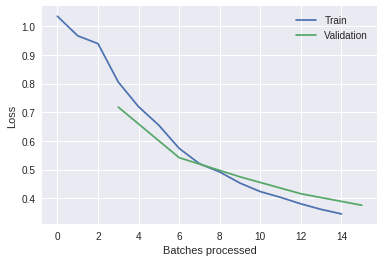

In [9]:
lr = 0.001
learn.fit_one_cycle(cyc_len=5, max_lr=lr)
learn.recorder.plot_losses()

# learn.recorder.plot_lr()
We use  [learn.recorder.plot_lr()](https://docs.fast.ai/basic_train.html#Recorder.plot_lr) to plot the learning rate.

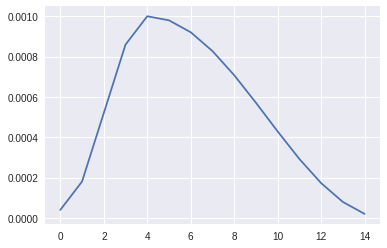

In [10]:
learn.recorder.plot_lr()

# ClassificationInterpretation()
We use  [ClassificationInterpretation()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) to visualize interpretations of our model.

In [0]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

# interp.plot_top_losses()
We can use [interp.plot_top_losses()](https://docs.fast.ai/vision.learner.html#plot_top_losses) to view our top losses and their details.

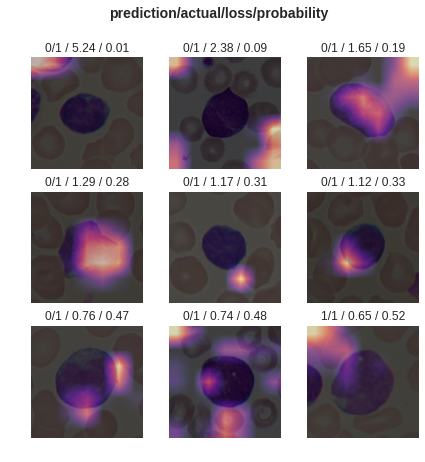

In [12]:
interp.plot_top_losses(9, figsize=(7,7))

# interp.plot_confusion_matrix()
Now we will use  [interp.plot_confusion_matrix()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation.plot_confusion_matrix) to display a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Below, 26 in the top left square represents 26 true negatives, while 0 in the top right square represents 0 false positives, 8 in the bottom left square represents 8 false negatives, and 17 in the bottom right represents 17 true positives.

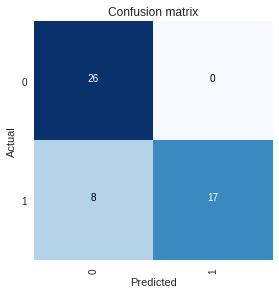

In [13]:
interp.plot_confusion_matrix()

# learn.unfreeze()
Next we use [learn.unfreeze()](https://docs.fast.ai/basic_train.html#Learner.unfreeze) to unfreeze the model.

In [0]:
learn.unfreeze()

# Train the entire (unfrozen) model
Now that we have unfrozen our model, we will use the following code blocks to train the whole model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


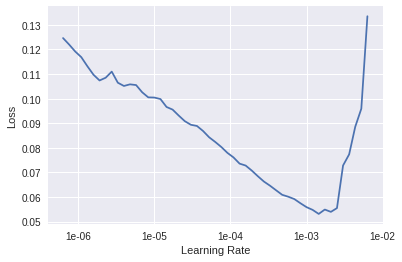

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
nlr = slice(1e-5, 1e-3)
learn.fit_one_cycle(5, nlr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.094796,0.303707,0.156863,0.843137,00:06
1,0.074144,0.134446,0.039216,0.960784,00:06
2,0.059263,0.241464,0.039216,0.960784,00:06
3,0.055622,0.225269,0.058823,0.941177,00:06
4,0.049124,0.173227,0.058823,0.941177,00:06


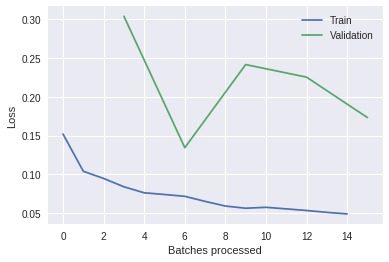

In [17]:
learn.recorder.plot_losses()

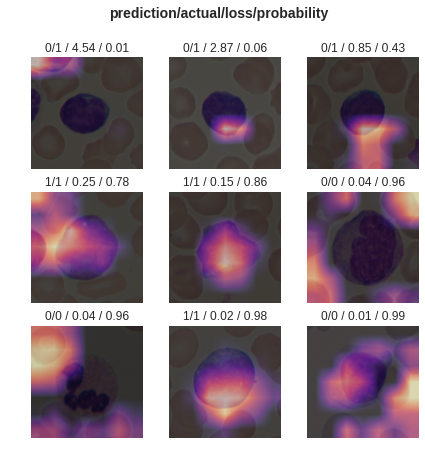

In [18]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

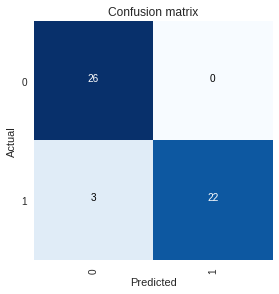

In [19]:
interp.plot_confusion_matrix()